In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

#Build and load the pretrained model
from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR

import csv

import pandas as pd
import numpy as np
import shutil
import os
from scipy.ndimage import gaussian_filter
import re

## 1. Model Part

In [2]:
# VG 150 enitiy classes and 50 relationship classes.

CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra'] 

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

In [3]:

position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8, 
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)

# The checkpoint is pretrained on Visual Genome
checkpoint_path = "./checkpoint0149.pth"
ckpt= torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(ckpt['model'])
model.eval()

c:\Users\tjsim\anaconda3\envs\rp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tjsim\anaconda3\envs\rp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RelTR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_

In [4]:
# Some transformation functions
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

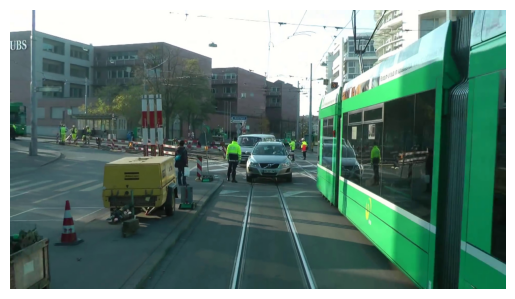

In [5]:
im = Image.open('../custom_images/0.jpg')
plt.axis("off")
plt.imshow(im)
plt.show()

## 2. Inference With Rules

In [6]:
# Rule 1
class_risk_scores_r1 = {
    'N/A': 0, 'airplane': 3, 'animal': 4, 'arm': 0, 'bag': 0, 'banana': 0, 'basket': 0, 'beach': 0, 'bear': 5,
    'bed': 0, 'bench': 0, 'bike': 8, 'bird': 2, 'board': 0, 'boat': 3, 'book': 0, 'boot': 0, 'bottle': 0, 'bowl': 0,
    'box': 0, 'boy': 5, 'branch': 0, 'building': 0, 'bus': 8, 'cabinet': 0, 'cap': 0, 'car': 8, 'cat': 4, 'chair': 0,
    'child': 5, 'clock': 0, 'coat': 0, 'counter': 0, 'cow': 4, 'cup': 0, 'curtain': 0, 'desk': 0, 'dog': 4, 'door': 0,
    'drawer': 0, 'ear': 0, 'elephant': 5, 'engine': 4, 'eye': 0, 'face': 0, 'fence': 0, 'finger': 0, 'flag': 0, 'flower': 0,
    'food': 0, 'fork': 0, 'fruit': 0, 'giraffe': 4, 'girl': 5, 'glass': 0, 'glove': 0, 'guy': 5, 'hair': 0, 'hand': 0,
    'handle': 0, 'hat': 0, 'head': 0, 'helmet': 2, 'hill': 0, 'horse': 4, 'house': 0, 'jacket': 0, 'jean': 0, 'kid': 5,
    'kite': 0, 'lady': 5, 'lamp': 0, 'laptop': 0, 'leaf': 0, 'leg': 0, 'letter': 0, 'light': 0, 'logo': 0, 'man': 5,
    'men': 5, 'motorcycle': 6, 'mountain': 2, 'mouth': 0, 'neck': 0, 'nose': 0, 'number': 0, 'orange': 0, 'pant': 0,
    'paper': 0, 'paw': 0, 'people': 5, 'person': 5, 'phone': 0, 'pillow': 0, 'pizza': 0, 'plane': 3, 'plant': 2, 'plate': 0,
    'player': 0, 'pole': 0, 'post': 0, 'pot': 0, 'racket': 0, 'railing': 0, 'rock': 2, 'roof': 2, 'room': 0, 'screen': 0,
    'seat': 0, 'sheep': 4, 'shelf': 0, 'shirt': 0, 'shoe': 0, 'short': 0, 'sidewalk': 0, 'sign': 0, 'sink': 0, 'skateboard': 0,
    'ski': 0, 'skier': 0, 'sneaker': 0, 'snow': 0, 'sock': 0, 'stand': 0, 'street': 4, 'surfboard': 0, 'table': 0, 'tail': 0,
    'tie': 0, 'tile': 0, 'tire': 0, 'toilet': 0, 'towel': 0, 'tower': 3, 'track': 2, 'train': 8, 'tree': 0, 'truck': 8,
    'trunk': 0, 'umbrella': 0, 'vase': 0, 'vegetable': 0, 'vehicle': 8, 'wave': 0, 'wheel': 0, 'window': 0, 'windshield': 0,
    'wing': 0, 'wire': 0, 'woman': 5, 'zebra': 4
}

relation_risk_scores_r1 = {
    '__background__': 0, 'above': 2, 'across': 3, 'against': 0, 'along': 4, 'and': 0, 'at': 1, 'attached to': 4,
    'behind': 6, 'belonging to': 0, 'between': 2, 'carrying': 4, 'covered in': 3, 'covering': 5, 'eating': 0,
    'flying in': 4, 'for': 0, 'from': 0, 'growing on': 0, 'hanging from': 3, 'has': 0, 'holding': 0, 'in': 2,
    'in front of': 8, 'laying on': 2, 'looking at': 0, 'lying on': 2, 'made of': 0, 'mounted on': 3, 'near': 8,
    'of': 0, 'on': 5, 'on back of': 4, 'over': 3, 'painted on': 0, 'parked on': 5, 'part of': 0, 'playing': 2,
    'riding': 6, 'says': 0, 'sitting on': 2, 'standing on': 3, 'to': 0, 'under': 4, 'using': 0, 'walking in': 7,
    'walking on': 7, 'watching': 0, 'wearing': 0, 'wears': 0, 'with': 0
}


In [9]:
def inference(im, im_name=None, class_risk_scores=class_risk_scores_r1, relation_risk_scores=relation_risk_scores_r1, 
              confidence=0.1, filter=False, save_all_relations_png=False):
    # 存储检测到的关系和边界框
    detected_relations = set()
    bbox_data = []
    relation_count=0
    num_relation_filtered = 0

    with torch.no_grad():
        # 传播模型
        outputs = model(transform(im).unsqueeze(0))

        # 过滤置信度0.+的预测
        sub_probas = outputs['sub_logits'].softmax(-1)[0, :, :-1]
        obj_probas = outputs['obj_logits'].softmax(-1)[0, :, :-1]
        rel_probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]

        # 计算置信度，并保留高于阈值的
        keep = torch.logical_and(
            sub_probas.max(-1).values > confidence,
            torch.logical_and(
                obj_probas.max(-1).values > confidence,
                rel_probas.max(-1).values > confidence
            )
        )

        # 如果有有效的预测
        if keep.any():
            sub_bboxes_scaled = rescale_bboxes(outputs['sub_boxes'][0, keep], im.size)
            obj_bboxes_scaled = rescale_bboxes(outputs['obj_boxes'][0, keep], im.size)

            # 获取关系的索引
            sub_indices = sub_probas[keep].argmax(-1)
            obj_indices = obj_probas[keep].argmax(-1)
            rel_indices = rel_probas[keep].argmax(-1)

            # 构建关系并记录边界框
            for sub_idx, obj_idx, rel_idx, sub_bbox, obj_bbox in zip(sub_indices, obj_indices, rel_indices, sub_bboxes_scaled, obj_bboxes_scaled):
                relation = (CLASSES[sub_idx], REL_CLASSES[rel_idx], CLASSES[obj_idx])
                if relation not in detected_relations:
                    detected_relations.add(relation)
                    bbox_data.append((sub_bbox, obj_bbox, relation))

    # 将检测到的关系保存到文件
    # 设置文件路径
    dir_name = './outputs'
    
    if im_name is not None:
        visul_rel_dir_name = f'./outputs/visual_relations_{im_name}'
        file_name = f'all_detected_relations_{im_name}.csv'
    else:
        visul_rel_dir_name = './outputs/visual_relations'
        file_name = f'all_detected_relations.csv'
    if save_all_relations_png:
        if not os.path.exists(visul_rel_dir_name):
            os.makedirs(visul_rel_dir_name)
    
    file_path = os.path.join(dir_name, file_name)
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Subject', 'Relationship', 'Object', 'Sub_bbox_xmin', 'Sub_bbox_ymin', 'Sub_bbox_xmax', 'Sub_bbox_ymax', 'Obj_bbox_xmin', 'Obj_bbox_ymin', 'Obj_bbox_xmax', 'Obj_bbox_ymax', 'risk_score_r1'])
        for _, (sub_bbox, obj_bbox, relation) in enumerate(bbox_data):
            risk_score = np.round((class_risk_scores.get(relation[0], 0) + relation_risk_scores.get(relation[1], 0) + class_risk_scores.get(relation[2], 0))/3, 2)
            
            # 转换Tensor为数值
            sub_bbox_values = [int(x.item()) if hasattr(x, 'item') else x for x in sub_bbox]
            obj_bbox_values = [int(x.item()) if hasattr(x, 'item') else x for x in obj_bbox]

            if filter:
                if class_risk_scores.get(relation[0], 0)== 0 or class_risk_scores.get(relation[2], 0)==0 or relation[0]==relation[2]:  #Filter out the entities with score 0(We don't care 'banana near car')
                    num_relation_filtered+=1
                    continue
                else:
                    writer.writerow([relation[0], relation[1], relation[2], *sub_bbox_values, *obj_bbox_values, risk_score])
                    relation_count+=1
            else:
                writer.writerow([relation[0], relation[1], relation[2], *sub_bbox_values, *obj_bbox_values, risk_score])
                relation_count+=1

    if save_all_relations_png:
        # 为每个独特的关系生成和保存图片
        for i, (sub_bbox, obj_bbox, relation) in enumerate(bbox_data):

            if im_name is not None:
                figure_path = os.path.join(visul_rel_dir_name, f'relation_image_{im_name}_{i}.png')
            else:
                figure_path = os.path.join(visul_rel_dir_name, f'relation_image_{i}.png')
            fig, ax = plt.subplots(1)
            ax.imshow(im)
            # Subject color blue
            ax.add_patch(plt.Rectangle((sub_bbox[0], sub_bbox[1]), sub_bbox[2] - sub_bbox[0], sub_bbox[3] - sub_bbox[1],
                                        fill=False, color='blue', linewidth=2.5))
            # Object color orange
            ax.add_patch(plt.Rectangle((obj_bbox[0], obj_bbox[1]), obj_bbox[2] - obj_bbox[0], obj_bbox[3] - obj_bbox[1],
                                        fill=False, color='orange', linewidth=2.5))
            ax.axis('off')
            relation_text = f'{relation[0]} {relation[1]} {relation[2]}'
            ax.set_title(relation_text, fontsize=10)
            plt.savefig(figure_path)
            plt.close()

    if im_name is not None:
        if filter:
            print(f"Generated and saved {relation_count} relations for {im_name} after {num_relation_filtered} relations filtered")
        else:
            print(f"Generated and saved {relation_count} relations for {im_name}")
    else:
        if filter:
            print(f"Generated and saved {relation_count} relations after {num_relation_filtered} relations filtered")
        else:
            print(f"Generated and saved {relation_count} relations")


In [31]:
inference(im, filter=True, save_all_relations_png=True)

Generated and saved 4 relations after 13 relations filtered


## 3. A Foundational Risk Evaluation Model

### 3.1 Risk Score Global

In [32]:
def calculate_risk_score_from_file(file_path):

    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Check if the DataFrame is empty
    if data.empty:
        return 0
    
    # Find the maximum value in the 'risk_score_r1' column
    max_risk_score = data['risk_score_r1'].max()
    
    return max_risk_score

In [33]:
risk_score = calculate_risk_score_from_file('./outputs/all_detected_relations.csv')
print(f"Global risk score for the image: {risk_score}")

Global risk score for the image: 7.0


### 3.2 Risk Heatmap

In [34]:
def visualization_all_with_scores(csv_path, im, silence=False, im_name=None):
    # 读取CSV文件
    df = pd.read_csv(csv_path)

    plt.figure(figsize=(16, 10))
    plt.imshow(im)

    # 绘制边界框和风险分数
    for index, row in df.iterrows():
        sub_bbox = [row['Sub_bbox_xmin'], row['Sub_bbox_ymin'], row['Sub_bbox_xmax'], row['Sub_bbox_ymax']]
        obj_bbox = [row['Obj_bbox_xmin'], row['Obj_bbox_ymin'], row['Obj_bbox_xmax'], row['Obj_bbox_ymax']]

        # 绘制主体边界框
        plt.gca().add_patch(plt.Rectangle((sub_bbox[0], sub_bbox[1]), sub_bbox[2] - sub_bbox[0], sub_bbox[3] - sub_bbox[1], linewidth=2, edgecolor='blue', facecolor='none'))
        # 绘制客体边界框
        plt.gca().add_patch(plt.Rectangle((obj_bbox[0], obj_bbox[1]), obj_bbox[2] - obj_bbox[0], obj_bbox[3] - obj_bbox[1], linewidth=2, edgecolor='red', facecolor='none'))

        # 标注风险分数
        plt.text(sub_bbox[0], sub_bbox[1], f"{row['risk_score_r1']:.2f}", color='white', fontsize=12, weight='bold')
    
    plt.axis('off')
    if im_name is not None:
        plt.title(f"visualization_all_with_scores_{im_name}(relTR, conf=0.1)")
        plt.savefig(f"./outputs/visual_all_with_scores_{im_name}_relTR.png")
    else:
        plt.title("visualization_all_with_scores(relTR, conf=0.1)")
        plt.savefig("./outputs/visual_all_with_scores_relTR.png")
    if silence:
        plt.close()
    else:
        plt.show()

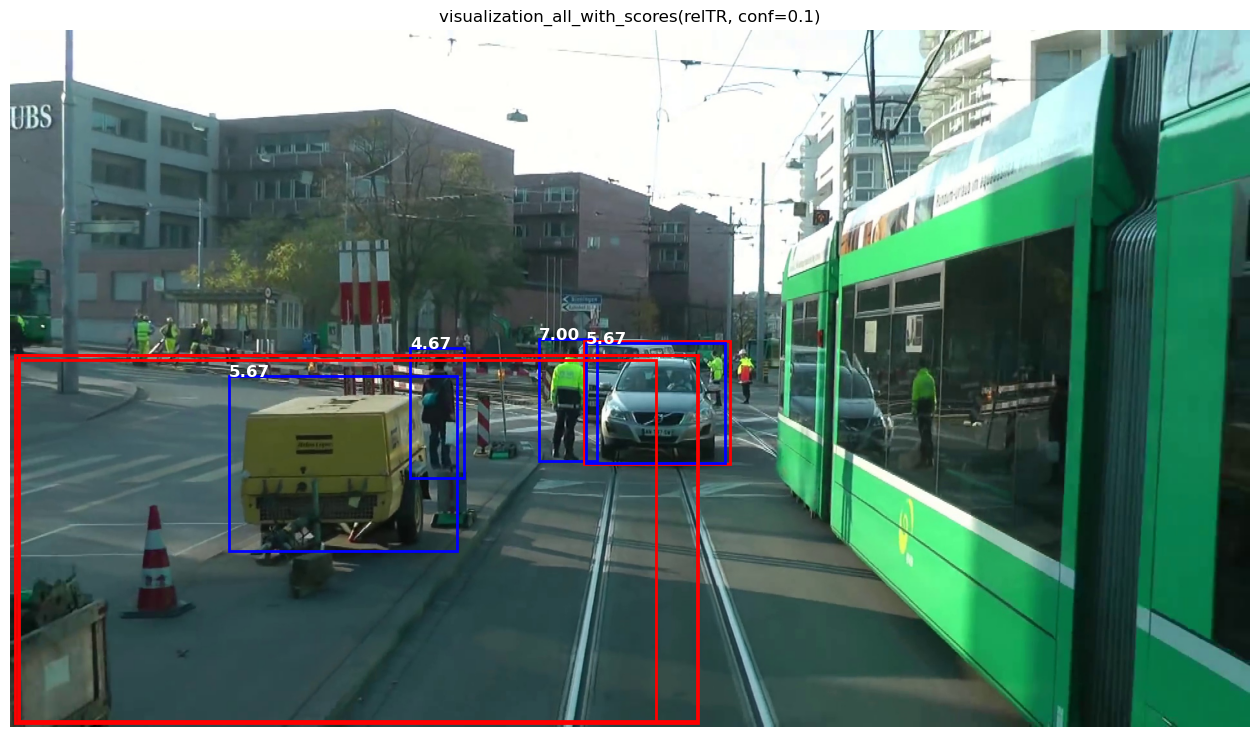

In [35]:
visualization_all_with_scores("./outputs/all_detected_relations.csv",  im)

In [36]:
def keep_risky_entities(csv_path, im, im_name=None, silence=False):

    sub_or_obj = []
    Bbox_xmin = []
    Bbox_ymin = []
    Bbox_xmax = []
    Bbox_ymax = []
    risk_score = []

    # 读取CSV文件
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(16, 10))
    plt.imshow(im)

    def bbox_area(bbox):
        return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

    # 绘制边界框和风险分数
    for index, row in df.iterrows():
        sub_bbox = [row['Sub_bbox_xmin'], row['Sub_bbox_ymin'], row['Sub_bbox_xmax'], row['Sub_bbox_ymax'],row['Subject']]
        obj_bbox = [row['Obj_bbox_xmin'], row['Obj_bbox_ymin'], row['Obj_bbox_xmax'], row['Obj_bbox_ymax'],row['Object']]

        # 计算边界框面积
        sub_area = bbox_area(sub_bbox)
        obj_area = bbox_area(obj_bbox)

        # 选择面积较小的边界框
        smaller_bbox = sub_bbox if sub_area < obj_area else obj_bbox
        edge_color = 'red' if sub_area < obj_area else 'blue'

        Bbox_xmin.append(smaller_bbox[0])
        Bbox_ymin.append(smaller_bbox[1])
        Bbox_xmax.append(smaller_bbox[2])
        Bbox_ymax.append(smaller_bbox[3])
        sub_or_obj.append(smaller_bbox[4])
        risk_score.append(float(row['risk_score_r1']))

        # 绘制边界框
        plt.gca().add_patch(plt.Rectangle((smaller_bbox[0], smaller_bbox[1]), smaller_bbox[2] - smaller_bbox[0], smaller_bbox[3] - smaller_bbox[1], linewidth=2, edgecolor=edge_color, facecolor='none'))

        # 标注风险分数
        plt.text(smaller_bbox[0], smaller_bbox[1], f"{row['risk_score_r1']:.2f}", color='white', fontsize=12, weight='bold')

    plt.axis('off')
    if im_name is not None:
        plt.title(f"keep_only_potential_risky_bbox_{im_name}(relTR, conf=0.1)")
        plt.savefig(f"./outputs/keep_only_potential_risky_bbox_{im_name}_relTR.png")
    else:
        plt.title("keep_only_potential_risky_bbox(relTR, conf=0.1)")
        plt.savefig("./outputs/keep_only_potential_risky_bbox_relTR.png")
    if silence:
        plt.close()
    else:
        plt.show()
    
    #保存风险Bbox
    dir_name = "./outputs"
    if im_name is not None:
        file_name = f"keep_only_potential_risky_bbox_{im_name}_relTR.csv"
    else:
        file_name = f"keep_only_potential_risky_bbox_relTR.csv"
    file_path = os.path.join(dir_name, file_name)
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Sub_or_Obj', 'Bbox_xmin', 'Bbox_ymin', 'Bbox_xmax', 'Bbox_ymax', 'risk_score_r1'])
        for i in range(len(sub_or_obj)):
            writer.writerow([sub_or_obj[i], Bbox_xmin[i], Bbox_ymin[i],Bbox_xmax[i], Bbox_ymax[i], risk_score[i]])


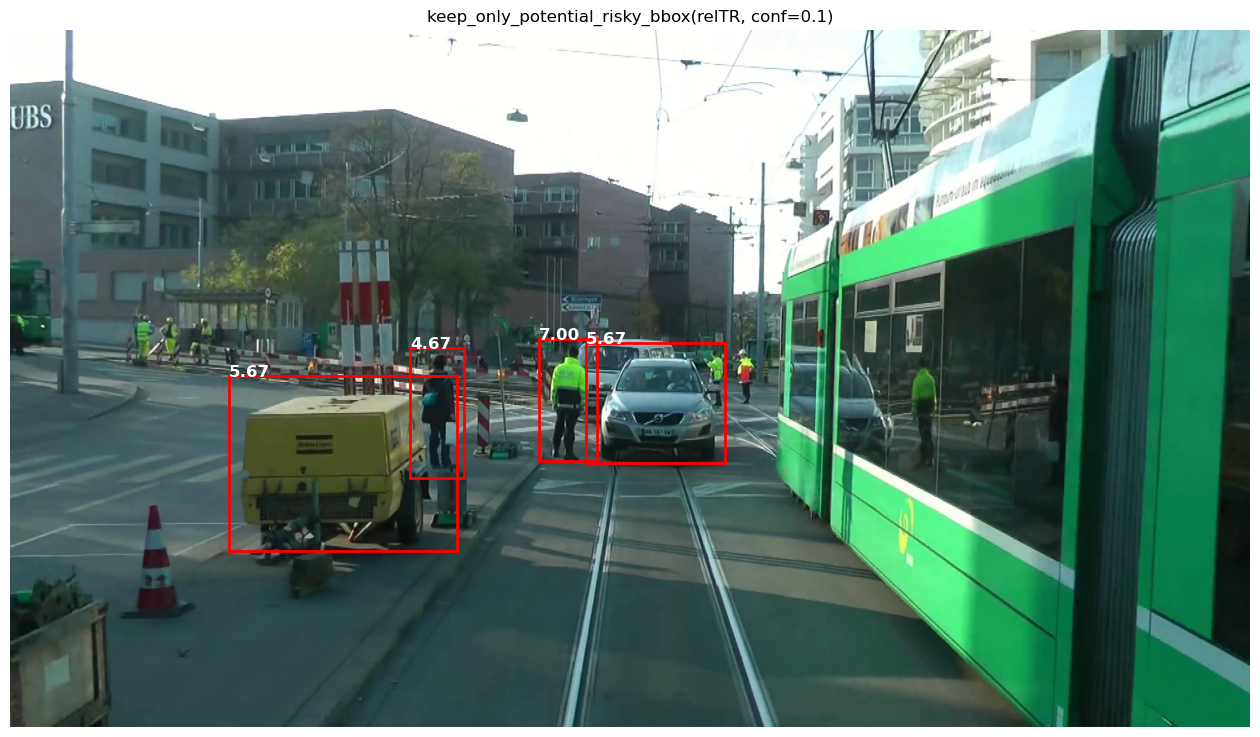

In [38]:
keep_risky_entities("./outputs/all_detected_relations.csv", im)

#### 3.2.1 Gaussian Heatmap

In [19]:
def create_gaussian_heatmap(csv_path, image, sigma, silence=False, im_name=None):

    image = np.array(image)
    image_shape =image.shape
    df = pd.read_csv(csv_path)

    # Initialize a heatmap to zeros
    heatmap = np.zeros(image_shape[:2])
    
    # Loop through the dataframe and add Gaussian blobs for each bounding box
    for index, row in df.iterrows():
        # Calculate the center of the bounding box
        center_x = int((row['Bbox_xmin'] + row['Bbox_xmax']) / 2)
        center_y = int((row['Bbox_ymin'] + row['Bbox_ymax']) / 2)
        risk_score = row['risk_score_r1']
        
        # Assuming that the center is within the bounds of the image
        if center_x >= 0 and center_y >= 0 and center_x < image_shape[1] and center_y < image_shape[0]:
            heatmap[center_y, center_x] = risk_score  # Set the risk score at the center

    # Apply a Gaussian filter to blur the heatmap
    gaussian_heatmap = gaussian_filter(heatmap, sigma=sigma) *1e4   #for values between 1-10

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    
    # Overlay the heatmap
    plt.imshow(gaussian_heatmap, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.axis('off')
    
    if im_name is not None:
        plt.title(f'gaussian_risk_heatmap_relTR_{im_name}(conf=0.1, sigma={sigma})')
        plt.savefig(f"./outputs/gaussian_risk_heatmap_relTR_{im_name}.png")
    else:
        plt.title(f'gaussian_risk_heatmap_relTR(conf=0.1, sigma={sigma})')
        plt.savefig("./outputs/gaussian_risk_heatmap_relTR.png")
    if silence:
        plt.close()
    else:
        plt.show()

    return gaussian_heatmap

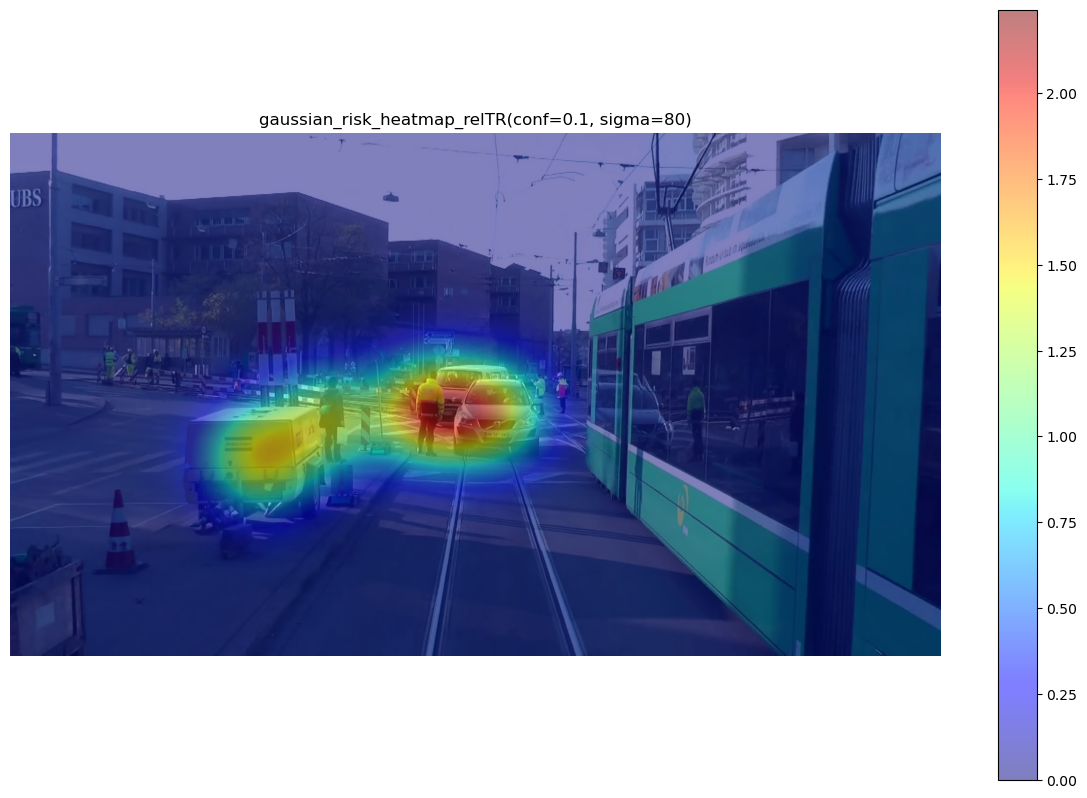

In [20]:
gaussian_heatmap = create_gaussian_heatmap("./outputs/keep_only_potential_risky_bbox.csv", im, sigma=80)

#### 3.2.1 Cumulative Heatmap

In [21]:
# Function to create the cumulative heatmap
def create_cumulative_heatmap(csv_path, im, silence=False, im_name=None):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    im_array = np.array(im)

    # Create an empty heatmap with the same dimensions as the image
    heatmap = np.zeros(im_array.shape[:2])

    # Iterate through the CSV rows and add the risk score to the heatmap
    for _, row in df.iterrows():
        bbox = (row['Bbox_xmin'], row['Bbox_ymin'], row['Bbox_xmax'], row['Bbox_ymax'])
        risk_score = row['risk_score_r1']
        # add the risk scores to the heatmap matrix
        x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        heatmap[y_min:y_max, x_min:x_max] += risk_score

    
    # Display the original image
    plt.figure(figsize=(15, 10))
    plt.imshow(im)
    plt.colorbar()
    plt.axis('off')

    # Overlay the heatmap
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    if im_name is not None:
        plt.title(f'cumulative_risk_heatmap_relTR_{im_name}(conf=0.1)')
        plt.savefig(f'./outputs/cumulative_risk_heatmap_relTR_{im_name}.png')
    else:
        plt.title('cumulative_risk_heatmap_relTR(conf=0.1)')
        plt.savefig('./outputs/cumulative_risk_heatmap_relTR.png')
    if silence:
        plt.close()
    else:
        plt.show()
    
    return heatmap

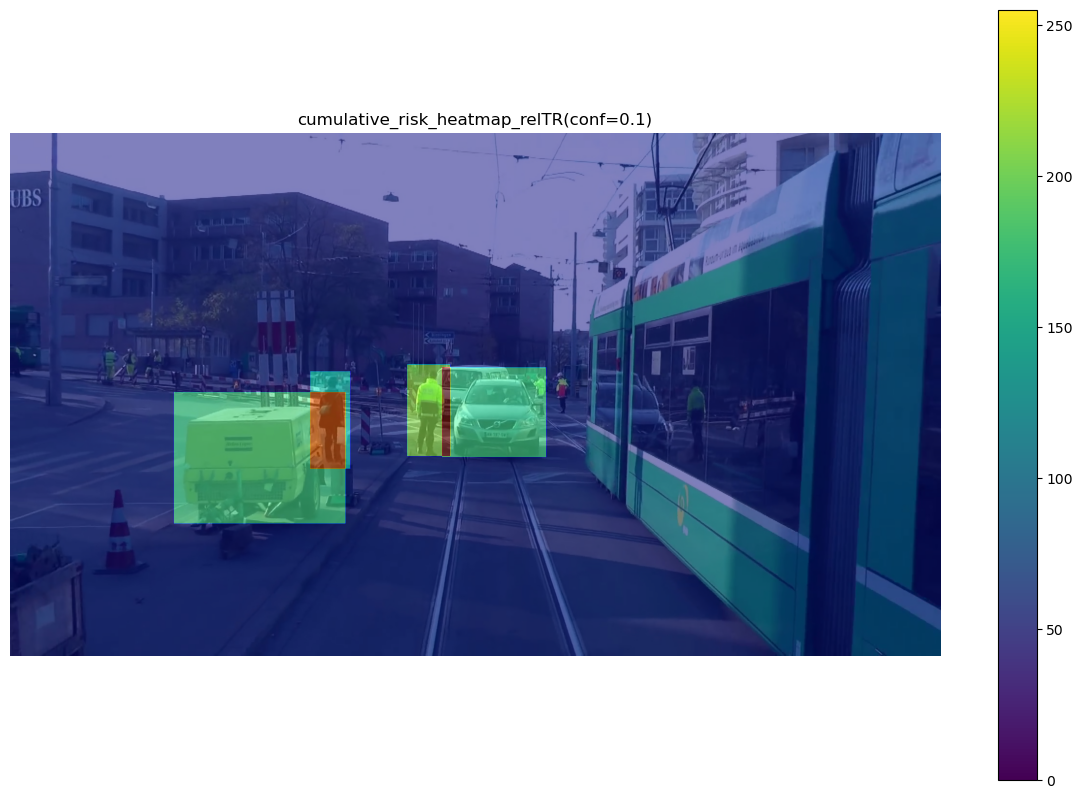

In [22]:
cumulative_heatmap = create_cumulative_heatmap("./outputs/keep_only_potential_risky_bbox.csv",im)

## 4. Inference And Risk Heatmaps Generation For All Custom Images

In [23]:
def clean_outputs_dir():
    dir_name='./outputs'
    # 确保目录存在
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # 获取目录中的所有文件和文件夹
    files = os.listdir(dir_name)

    # 遍历目录中的所有文件和文件夹
    for file in files:
        file_path = os.path.join(dir_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)  # 删除文件
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # 递归删除文件夹及其内容
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")

In [42]:

def all(imgs_dir, class_risk_scores=class_risk_scores_r1, relation_risk_scores=relation_risk_scores_r1, confidence=0.1, sigma=80):

    im_list = []
    im_name_list = []
    #gaussian_heatmap_list = []
    #cumulative_heatmap_list = []

    def sort_numerically(filename):
        """
        This function extracts the numerical part of the filename and returns it as an integer.
        """
        numbers = re.findall(r'\d+', filename)
        return int(numbers[0]) if numbers else 0

    for filename in sorted(os.listdir(imgs_dir), key=sort_numerically):
        file_path = os.path.join(imgs_dir, filename)
        with Image.open(file_path) as im:
            im_list.append(im.copy())
        
        # Create a name for the image, remove the .jpg extension, and prepend 'img'
        im_name = "img" + os.path.splitext(filename)[0]
        im_name_list.append(im_name)

    clean_outputs_dir()  #clean outputs dir

    global_score_file_path = "./outputs/global_risk_score_custom_imgs_RelTR.csv"
    with open(global_score_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Img_name', 'Global_score'])

        for i, im in enumerate(im_list):
            im_name = im_name_list[i]
            print("===========================================================")
            print(f"Start Inference And Risk Heatmaps Generation For {im_name}")
            print("===========================================================")
            inference(im, im_name, class_risk_scores, relation_risk_scores, confidence, filter=True)
            print(f'all_detected_relations_{im_name}.csv is saved.')
            csv_all_file_path = os.path.join('./outputs', f'all_detected_relations_{im_name}.csv')
            risk_score = calculate_risk_score_from_file(csv_all_file_path)
            writer.writerow([im_name, risk_score])
            visualization_all_with_scores(csv_all_file_path, im, silence=True, im_name=im_name)
            print(f"visual_all_with_scores_{im_name}_relTR.png is saved.")
            keep_risky_entities(csv_all_file_path, im, im_name=im_name, silence=True)
            print(f"keep_only_potential_risky_bbox_{im_name}_relTR.png is saved.")
            print(f"keep_only_potential_risky_bbox_{im_name}.csv is saved.")
            csv_keep_file_path = os.path.join('./outputs', f"keep_only_potential_risky_bbox_{im_name}_relTR.csv")
            gaussian_heatmap = create_gaussian_heatmap(csv_keep_file_path, im, sigma, silence=True, im_name=im_name)
            #gaussian_heatmap_list.append(gaussian_heatmap)
            print(f"gaussian_risk_heatmap_relTR_{im_name}.png is saved.")
            cumulative_heatmap = create_cumulative_heatmap(csv_keep_file_path, im, silence=True, im_name=im_name)
            #cumulative_heatmap_list.append(cumulative_heatmap)
            print(f'cumulative_risk_heatmap_relTR_{im_name}.png is saved')
            print(f"\nEnd For {im_name}\n\n")

        print(f"global_risk_score.csv is saved.")
        print("All processes have been completed and all outputs saved successfully!") 
        #return gaussian_heatmap_list, cumulative_heatmap_list

In [43]:
imgs_dir="../custom_images"
all(imgs_dir)

Start Inference And Risk Heatmaps Generation For img0
Generated and saved 4 relations for img0 after 13 relations filtered
all_detected_relations_img0.csv is saved.
visual_all_with_scores_img0_relTR.png is saved.
keep_only_potential_risky_bbox_img0_relTR.png is saved.
keep_only_potential_risky_bbox_img0.csv is saved.
gaussian_risk_heatmap_relTR_img0.png is saved.
cumulative_risk_heatmap_relTR_img0.png is saved

End For img0


Start Inference And Risk Heatmaps Generation For img1
Generated and saved 6 relations for img1 after 13 relations filtered
all_detected_relations_img1.csv is saved.
visual_all_with_scores_img1_relTR.png is saved.
keep_only_potential_risky_bbox_img1_relTR.png is saved.
keep_only_potential_risky_bbox_img1.csv is saved.
gaussian_risk_heatmap_relTR_img1.png is saved.
cumulative_risk_heatmap_relTR_img1.png is saved

End For img1


Start Inference And Risk Heatmaps Generation For img2
Generated and saved 0 relations for img2 after 4 relations filtered
all_detected_relat

In [ ]:
def only_save_global_risk_score_for_all(imgs_dir, global_score_file_path, class_risk_scores=class_risk_scores_r1, 
        relation_risk_scores=relation_risk_scores_r1, confidence=0.1):
    
    im_list = []
    im_name_list = []
    #gaussian_heatmap_list = []
    #cumulative_heatmap_list = []

    def sort_numerically(filename):
        """
        This function extracts the numerical part of the filename and returns it as an integer.
        """
        numbers = re.findall(r'\d+', filename)
        return int(numbers[0]) if numbers else 0

    for filename in sorted(os.listdir(imgs_dir), key=sort_numerically):
        file_path = os.path.join(imgs_dir, filename)
        with Image.open(file_path) as im:
            im_list.append(im.copy())
        
        # Create a name for the image, remove the .jpg extension, and prepend 'img'
        im_name = "img" + os.path.splitext(filename)[0]
        im_name_list.append(im_name)

    clean_outputs_dir()  #clean outputs dir

    with open(global_score_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Img_name', 'Global_score'])

        for i, im in enumerate(im_list):
            im_name = im_name_list[i]
            inference(im, im_name, class_risk_scores, relation_risk_scores, confidence, filter=True)
            csv_all_file_path = os.path.join('./outputs', f'all_detected_relations_{im_name}.csv')
            risk_score = calculate_risk_score_from_file(csv_all_file_path)
            writer.writerow([im_name, risk_score])
    
    print("All processes have been completed and csv saved successfully!")

In [11]:
imgs_dir="../rs19_val_imgs"
global_score_file_path = "./outputs/global_score_for_rs19_relTR.csv"
only_save_global_risk_score_for_all(imgs_dir, global_score_file_path)

Generated and saved 0 relation images for img0.
Generated and saved 2 relation images for img1.
Generated and saved 0 relation images for img2.
Generated and saved 1 relation images for img3.
Generated and saved 2 relation images for img4.
Generated and saved 0 relation images for img5.
Generated and saved 2 relation images for img6.
Generated and saved 1 relation images for img7.
Generated and saved 1 relation images for img8.
Generated and saved 1 relation images for img9.
Generated and saved 0 relation images for img10.
Generated and saved 0 relation images for img11.
Generated and saved 1 relation images for img12.
Generated and saved 0 relation images for img13.
Generated and saved 1 relation images for img14.
Generated and saved 2 relation images for img15.
Generated and saved 2 relation images for img16.
Generated and saved 2 relation images for img17.
Generated and saved 0 relation images for img18.
Generated and saved 2 relation images for img19.
Generated and saved 1 relation

## 5. Global Risk Score Accuracy

2831 images

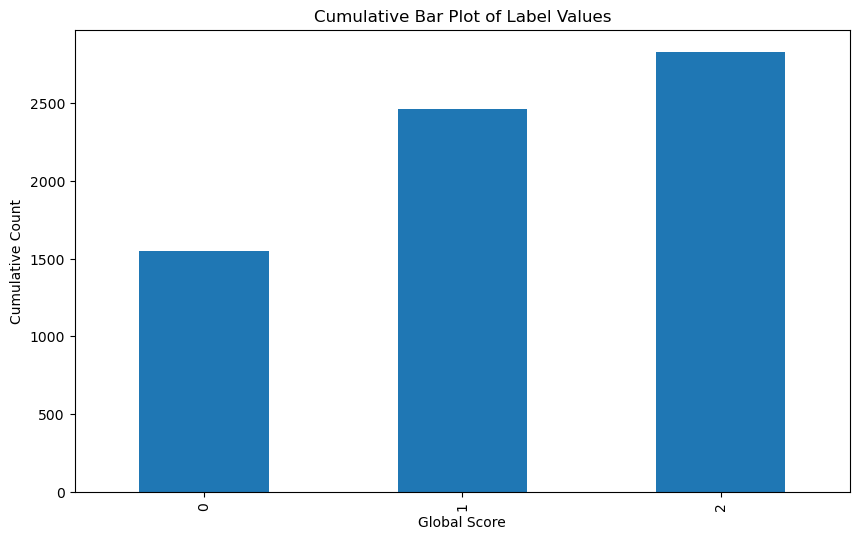

In [44]:
label_csv_path = "../labels.csv"
label_data = pd.read_csv(label_csv_path, sep=';',names=['Name','General_risk(0-1-2)','Weather[0-10]',
                                                        'Light[0-10]','Users[0-10]','Context[0-10]'],skiprows=1).iloc[:2831]
label_values = label_data['General_risk(0-1-2)']
label_value_counts = label_values.value_counts().sort_index()

# Plot cumulative bar plot
plt.figure(figsize=(10, 6))
label_value_counts.cumsum().plot(kind='bar')
plt.xlabel('Global Score')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Bar Plot of Label Values')
plt.show()

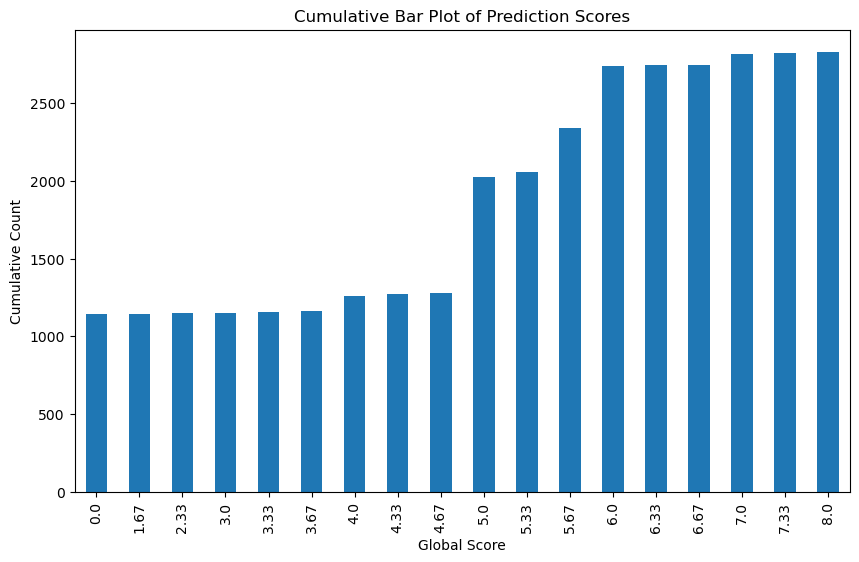

In [47]:
prediction_csv_path = './outputs/global_score_for_rs19_relTR.csv'

# Load the prediction data
pred_data = pd.read_csv(prediction_csv_path, names=['Img_name', 'Global_score'], skiprows=1)


prediction_values = pred_data['Global_score']
# Get counts for each unique value
pred_value_counts = prediction_values.value_counts().sort_index()

# Plot cumulative bar plot
plt.figure(figsize=(10, 6))
pred_value_counts.cumsum().plot(kind='bar')
plt.xlabel('Global Score')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Bar Plot of Prediction Scores')
plt.show()


In [48]:
label_value_counts.cumsum()

General_risk(0-1-2)
0    1547
1    2462
2    2831
Name: count, dtype: int64

In [49]:
pred_value_counts.cumsum()

Global_score
0.00    1142
1.67    1143
2.33    1147
3.00    1150
3.33    1157
3.67    1160
4.00    1262
4.33    1273
4.67    1281
5.00    2026
5.33    2059
5.67    2341
6.00    2736
6.33    2743
6.67    2746
7.00    2815
7.33    2821
8.00    2831
Name: count, dtype: int64

In [50]:
# <=5   --> 0
# >5 <=6   -->1
# >6   -->2

def apply_thresholds(score, thresholds):
    if score <= thresholds[0]:
        return 0
    elif score <= thresholds[1]:
        return 1
    else:
        return 2

thresholds = [5, 6]

# Normalize the prediction scores based on the thresholds
normalized_pred_scores = prediction_values.apply(lambda x: apply_thresholds(x, thresholds))

In [51]:
# Calculate the accuracy
accuracy = np.mean(normalized_pred_scores == label_values)
accuracy

0.5259625574002119